In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ip = "52.233.29.106"
duckdb.sql("INSTALL postgres;")
duckdb.sql("LOAD postgres;")
duckdb.sql(f"ATTACH 'dbname=postgres user=postgres host={ip} password=template!PWD' AS db (TYPE POSTGRES);")


In [3]:
#from db.database import Database
#Database.clear()

In [4]:
duckdb.query("""
SELECT * FROM db.public.compute_configs
""")

┌──────────────────────────────────────┬────────────────────────────────┬────────────────────────┐
│                run_id                │       team_distribution        │      batch_sizes       │
│                 uuid                 │            varchar             │        varchar         │
├──────────────────────────────────────┼────────────────────────────────┼────────────────────────┤
│ 10ec8fee-6603-4de3-8c67-5ae287c33d56 │ [("alice", 180), ("bob", 180)] │ {"alice": 8, "bob": 8} │
│ b24e3011-5d62-4b2c-97f0-a8f996b88027 │ [("alice", 360)]               │ {"alice": 8}           │
│ 28febfb1-4218-4943-af34-5d27fc2a8dce │ [("alice", 360)]               │ {"alice": 1}           │
│ 22537673-58e4-47c3-8d3f-69cef96e6ac4 │ [("alice", 180), ("bob", 180)] │ {"alice": 8, "bob": 8} │
│ 1aea2400-dcad-48b8-ab59-6a036f1ebaa4 │ [("alice", 180), ("bob", 180)] │ {"alice": 8, "bob": 8} │
│ 86bab8cc-9002-4a97-8d12-8285163dd306 │ [("alice", 360)]               │ {"alice": 8}           │
│ 1e25b5b0

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

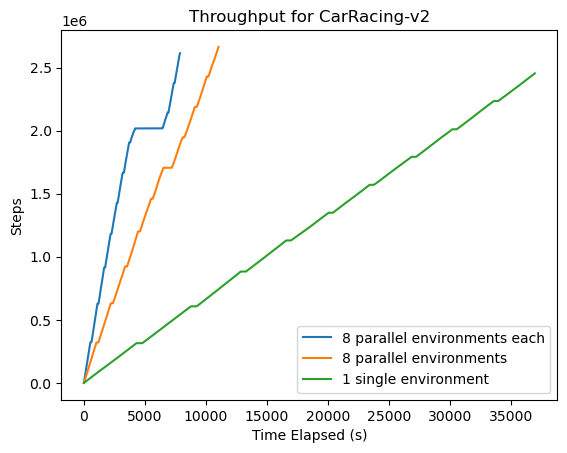

In [5]:
df_2_workers = duckdb.query("""
SELECT time, COUNT(*) OVER (ORDER BY time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as num_steps
FROM db.public.training
WHERE run_id = '1aea2400-dcad-48b8-ab59-6a036f1ebaa4'
ORDER BY time
""").df()

df_1_worker = duckdb.query("""
SELECT time, COUNT(*) OVER (ORDER BY time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as num_steps
FROM db.public.training
WHERE run_id = '86bab8cc-9002-4a97-8d12-8285163dd306'
ORDER BY time
""").df()

df_single_thread = duckdb.query("""
SELECT time, COUNT(*) OVER (ORDER BY time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as num_steps
FROM db.public.training
WHERE run_id = '1e25b5b0-a62c-41fb-ac24-6536fbc145d8'
ORDER BY time
""").df()

for df in [df_2_workers, df_1_worker, df_single_thread]:
    df['elapsed_time'] = df['time'] - df['time'].min()


plt.plot(df_2_workers['elapsed_time'], df_2_workers['num_steps'], label='8 parallel environments each')
plt.plot(df_1_worker['elapsed_time'], df_1_worker['num_steps'], label='8 parallel environments')
plt.plot(df_single_thread['elapsed_time'], df_single_thread['num_steps'], label='1 single environment')

plt.ylabel('Steps')
plt.xlabel('Time Elapsed (s)')
plt.title("Throughput for CarRacing-v2")
plt.legend()

plt.savefig(f"./figures/throughput.png")

In [6]:
duckdb.query("""
SELECT * FROM db.public.training
WHERE run_id = 'b9eef7ce-d89b-4a0f-9679-9b1520de2772'
ORDER BY time DESC
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────┬────────────┬─────────┬─────────────┬────────┬───────────┬────────┬────────┐
│ run_id │ generation │ team_id │ is_finished │ reward │ time_step │  time  │ action │
│  uuid  │   int32    │  uuid   │   boolean   │ double │   int32   │ double │ int32  │
├────────┴────────────┴─────────┴─────────────┴────────┴───────────┴────────┴────────┤
│                                       0 rows                                       │
└────────────────────────────────────────────────────────────────────────────────────┘

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

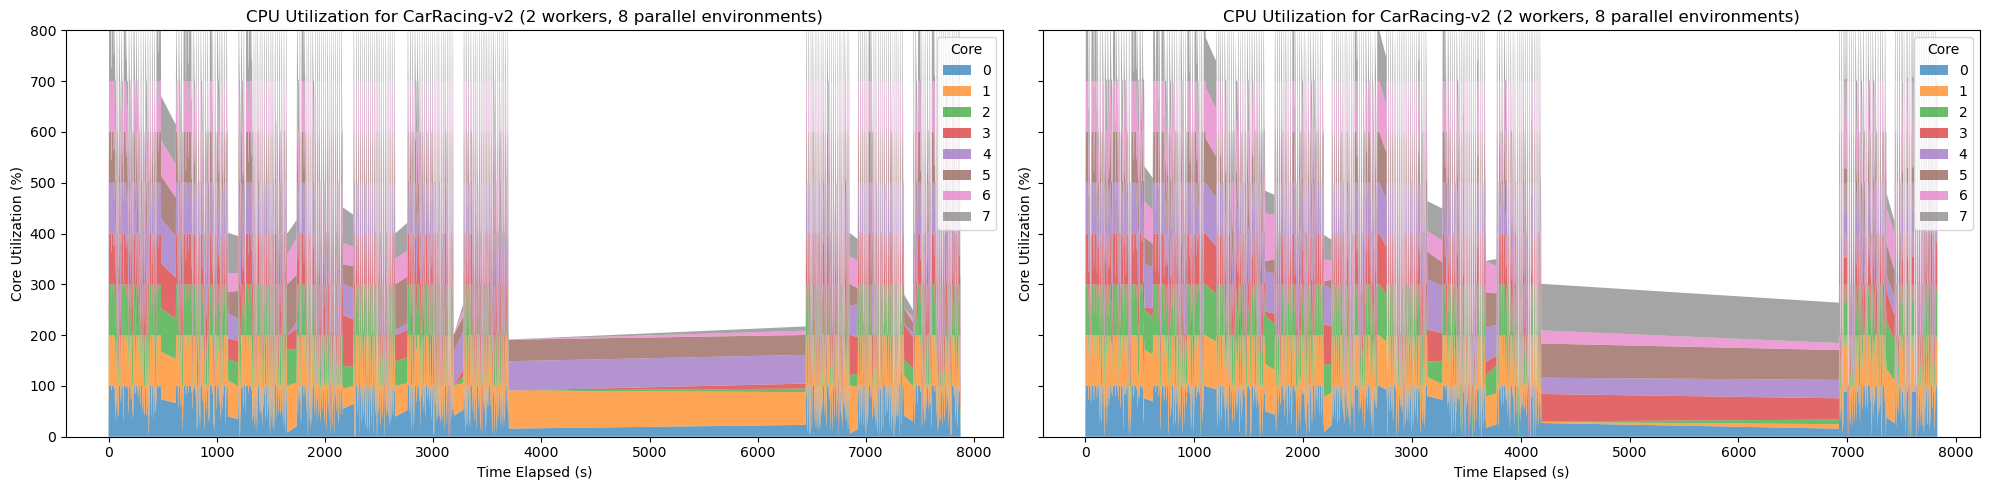

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

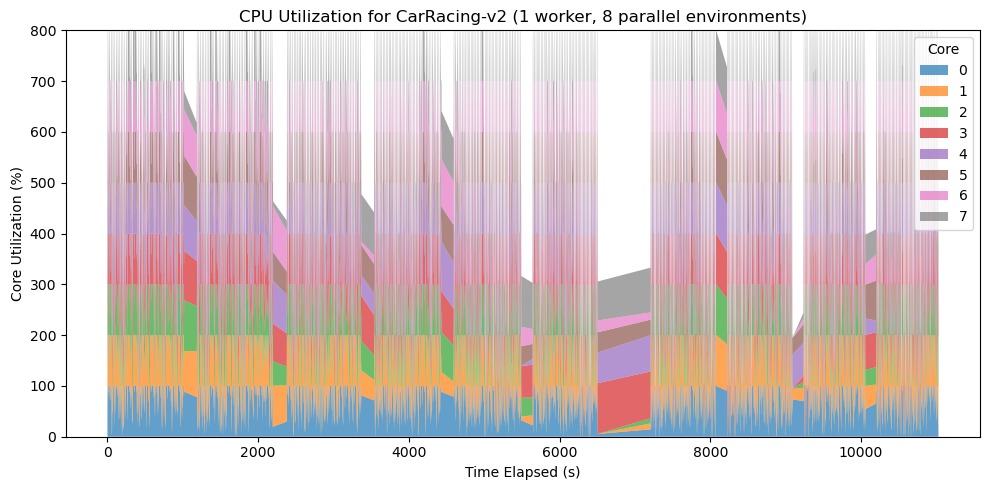

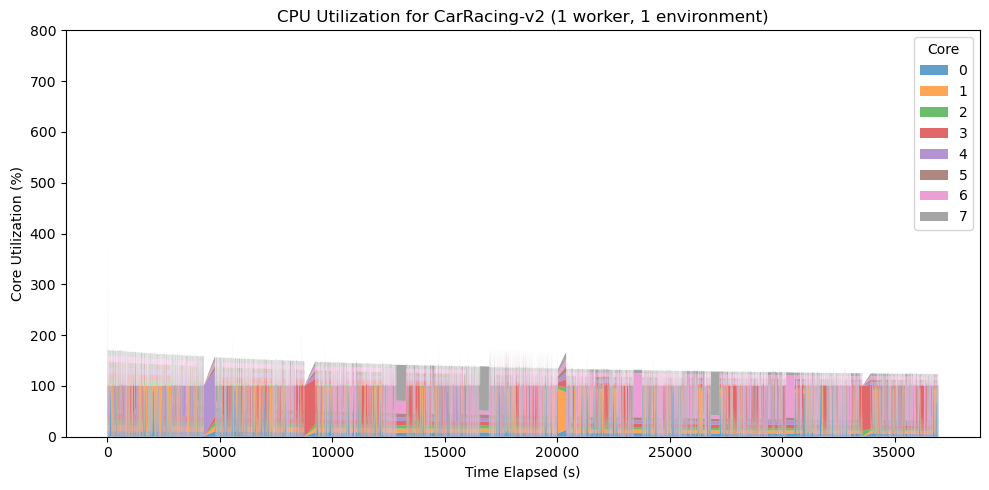

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from scipy.ndimage import gaussian_filter1d

# Define the runs and their corresponding workers
runs = {
    '1aea2400-dcad-48b8-ab59-6a036f1ebaa4': ['alice', 'bob'],
    '86bab8cc-9002-4a97-8d12-8285163dd306': ['alice'],
    '1e25b5b0-a62c-41fb-ac24-6536fbc145d8': ['alice']
}

# Define smoothing function
def smooth_data(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

for run, workers in runs.items():
    # Determine if we need side-by-side subplots
    num_workers = len(workers)
    fig, axs = plt.subplots(1, num_workers, figsize=(10 * num_workers, 5), sharey=True)
    
    if num_workers == 1:
        axs = [axs]  # Ensure axs is iterable
    
    for i, worker in enumerate(workers):
        # Query and prepare the data
        df = duckdb.query(f"""
        SELECT * FROM db.public.cpu_utilization
        WHERE worker = '{worker}'
        AND run_id = '{run}'
        """).df()
    
        # Calculate time elapsed
        df['time_elapsed'] = df['time'] - df['time'].min()
    
        # Pivot the DataFrame for plotting
        pivot_df = df.pivot_table(index='time_elapsed', columns='core', values='utilization', aggfunc='mean')
    
        # Smooth the data
        window_size = 5  # Adjust window size as needed
        smoothed_df = pivot_df.apply(lambda x: smooth_data(pd.Series(x), window_size))
    
        # Plot on the appropriate axis
        axs[i].stackplot(smoothed_df.index, smoothed_df.T, labels=smoothed_df.columns, alpha=0.7)
    
        # Set titles based on worker type and configuration
        if run == '1aea2400-dcad-48b8-ab59-6a036f1ebaa4':
            config = "2 workers, 8 parallel environments"
        elif run == '86bab8cc-9002-4a97-8d12-8285163dd306':
            config = "1 worker, 8 parallel environments"
        elif run == '1e25b5b0-a62c-41fb-ac24-6536fbc145d8':
            config = "1 worker, 1 environment"
        
        title = f'CPU Utilization for CarRacing-v2 ({config})'
        
        axs[i].set_title(title)
        axs[i].set_xlabel('Time Elapsed (s)')
        axs[i].set_ylabel('Core Utilization (%)')
        axs[i].set_ylim(0, 800)
        axs[i].legend(title='Core')
    
    plt.tight_layout()

    plt.savefig(f"./figures/{run}_cpu_utilization.png")
    plt.show()
    
    # Close the figure
    plt.close()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

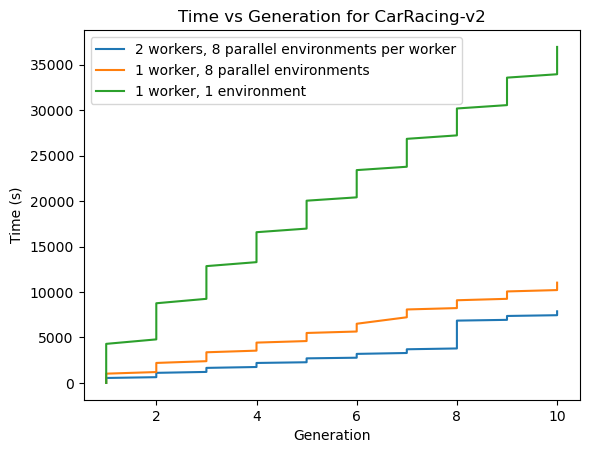

In [8]:
import matplotlib.pyplot as plt

for run in ['1aea2400-dcad-48b8-ab59-6a036f1ebaa4','86bab8cc-9002-4a97-8d12-8285163dd306', '1e25b5b0-a62c-41fb-ac24-6536fbc145d8']:
    df = duckdb.query(f"""
    SELECT * FROM db.public.training
    WHERE run_id = '{run}'
    ORDER BY generation, time
    """).df()
    
    df['time_elapsed'] = df['time'] - df['time'].min()

    if run == '1aea2400-dcad-48b8-ab59-6a036f1ebaa4':
        plt.plot(df['generation'], df['time_elapsed'], label="2 workers, 8 parallel environments per worker")
    elif run == '86bab8cc-9002-4a97-8d12-8285163dd306':
        plt.plot(df['generation'], df['time_elapsed'], label="1 worker, 8 parallel environments")
    elif run == '1e25b5b0-a62c-41fb-ac24-6536fbc145d8':
        plt.plot(df['generation'], df['time_elapsed'], label="1 worker, 1 environment")
        
    plt.title("Time vs Generation for CarRacing-v2")
    plt.ylabel("Time (s)")
    plt.xlabel("Generation")
    plt.legend()

plt.savefig(f"./figures/time_vs_generation.png")